**Anomaly Detection on Spacecraft Data:**

In the most general sense, Anomaly detection is the task of detecting rare events or outliers in the time series data. Here manouvers are treated as anomaly spacecraft's trajectory time series data of Semi Major Axis. LSTM Autoencoder is employed in case of anomaly detection. Other approaches like GAN and it's variants are also useful methods. Autoencoder based methods are reconstruction error based methods.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8


**Load and Inspect the Spacecraft Data**

In [2]:
df = pd.read_csv('/content/sample_data/SMA_data.csv')
print(df)
print(df.columns)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Datetime, y=df.SMA, mode='lines', name='SMA'))
fig.update_layout(showlegend=True)
fig.show()

                        Datetime          SMA
0     2018-01-01 04:34:10.320672  6864.691463
1     2018-01-01 12:37:36.596064  6864.689664
2     2018-01-01 20:31:55.898112  6864.688585
3     2018-01-02 05:42:49.014720  6864.684927
4     2018-01-02 12:13:01.263360  6864.682858
...                          ...          ...
2286  2019-12-30 03:03:24.992640  6872.930137
2287  2019-12-30 11:05:46.768704  6872.928514
2288  2019-12-30 19:01:25.464576  6872.927281
2289  2019-12-31 10:44:01.110912  6872.923732
2290  2019-12-31 18:43:37.271136  6872.922860

[2291 rows x 2 columns]
Index(['Datetime', 'SMA'], dtype='object')


**Data Preprocessing**

We shall do some data-preprocessing that will involve

Standardizing the target-vector by removing the mean and scaling it to the unit variance, using the standard_scaler function from sklearn.preprocessing.
We need to split the data to training and testing sets, which we must do before standardizing it.


In [3]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(1832, 2) (459, 2)


Now let's standardize the data set.

1. first we import and instantiate standard_scaler,
2. Then fit the train SMA feature to standard_scaler
3. Then transform the train SMA feature by standard scaler
4. Then we transform test SMA feature too.

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[['SMA']])

train['SMA'] = scaler.transform(train[['SMA']])
test['SMA'] = scaler.transform(test[['SMA']])

Since this is a time-series modelling project, we need to split our data into sub-sequences before using it to train our model. We can create sequences with specific time-steps. In our case we set time_steps=30. Meaning we create sequences with 30 days worth of historical data.
And as required by LSTM networks, we need to reshape our data into the shape **n_samples by n(time_steps) by n(features)**.

Here, our n(features)is just one and n(time_steps) is 30.

**Temporalize Data and create Training and Test splits**

To deal with LSTM networks, we need to temporalize our data, and reshape our data. Let's define a simple method that can help us, since we must repeat same process for X_train, X_test, y_train and y_test arrays.

In [5]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps=30
X_train, y_train = create_sequences(train[['SMA']], train.SMA, time_steps)
X_test, y_test = create_sequences(test[['SMA']], test.SMA, time_steps)
print(X_train.shape)

(1802, 30, 1)


**Build an LSTM Auto-Encoder in Keras**

Here we'd build an LSTM auto-encoder network and visualize its architecture and data flow. Here are the steps:

We train an auto-encoder on data with no anomalies
Then take a new data point and try to reconstruct it using the auto-encoder
If the reconstruction error for the new data point is above some set threshold, we'd label that data point as an anomaly.

In [6]:
# Let's define variables we'd need for our LSTM as a function of Training data.
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [7]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


In [8]:
# Next we use the Sequential layer and basically stack all needed layers in it.
model = Sequential([
    # We pass the input shape to the model
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    # If subsequent layer is an LSTM, we need to duplicate
    # This using the repeatVector layer. This replicates the
    # Feature vector from the LSTM layer output, timesteps times
    RepeatVector(timesteps),
    # The encoder has been done, now we mirror the encoder
    # in reverse fashion.These are the steps for creating
    # The decoder. Note the RepeatVector layer acts as a bridge
    # Between the encoding and the decoding modules. It prepares
    # The 2D array input for first LSTM layer in decoder.
    LSTM(128, return_sequences=True),
    # The return_sequence=True makes each timestep return a
    # signal. Let's add another dropout layer
    Dropout(0.2),
    # Next we add the timedistributed layer (TDL) at the end,
    # So we get the output with the right shape
    TimeDistributed(Dense(num_features))
    # TDL creates a vector of length=num_features outputted from
    # The previous layer. Since prev layer outputs 128 features,
    # TDL creates a 128 long vector and duplicates it the
    # num_feature times.
])

# Next let's compile the model
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

**Train the Auto-Encoder**

Time to train the model, after compiling it. Let's apply the early stopper regularization technique called call_backs. This way, we don't need to hard-code the number of epochs the model will train on. Rather by specifying a metric to watch, we can stop training the moment the model stops improving in learning and starts over-fitting.

The code below means, we monitor the validation loss metric and if it's not reducing for 5 consecutive epochs, then we stop the training and take the minimum validation loss parameters.

In [9]:
# Next, let's train the model. Batch size is the number of features the model
# Should train before updating its weights. It's a hyper-par we can sure tweak.
# We set epochs real high to give leeway for callbacks to work.
# validation_split:- keep specified percent for validating, use rest to train
# Make sure value of callback is in a list.
# Finally, dont shuffle time-series data. order matters. So, shuffle=False

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/100
51/51 [==============================] - 13s 110ms/step - loss: 0.1468 - val_loss: 0.1939
Epoch 2/100
51/51 [==============================] - 4s 84ms/step - loss: 0.1218 - val_loss: 0.1646
Epoch 3/100
51/51 [==============================] - 6s 121ms/step - loss: 0.1127 - val_loss: 0.3586
Epoch 4/100
51/51 [==============================] - 4s 81ms/step - loss: 0.1844 - val_loss: 0.6852
Epoch 5/100
51/51 [==============================] - 5s 104ms/step - loss: 0.1457 - val_loss: 0.2081
Epoch 6/100
51/51 [==============================] - 5s 101ms/step - loss: 0.1763 - val_loss: 0.6472
Epoch 7/100
51/51 [==============================] - 4s 81ms/step - loss: 0.1278 - val_loss: 0.1083
Epoch 8/100
51/51 [==============================] - 6s 126ms/step - loss: 0.1062 - val_loss: 0.2660
Epoch 9/100
51/51 [==============================] - 4s 82ms/step - loss: 0.1004 - val_loss: 0.0696
Epoch 10/100
51/51 [==============================] - 5s 92ms/step - loss: 0.0855 - val_loss: 

**Plot Metrics and Evaluate the Model**

Let's now plot our metrics, which is the training loss and validation loss.Loss values are stored in the history.history object. So we can use this to plot the losses. The history object is a dictionary so we choose the keys we want to plot.

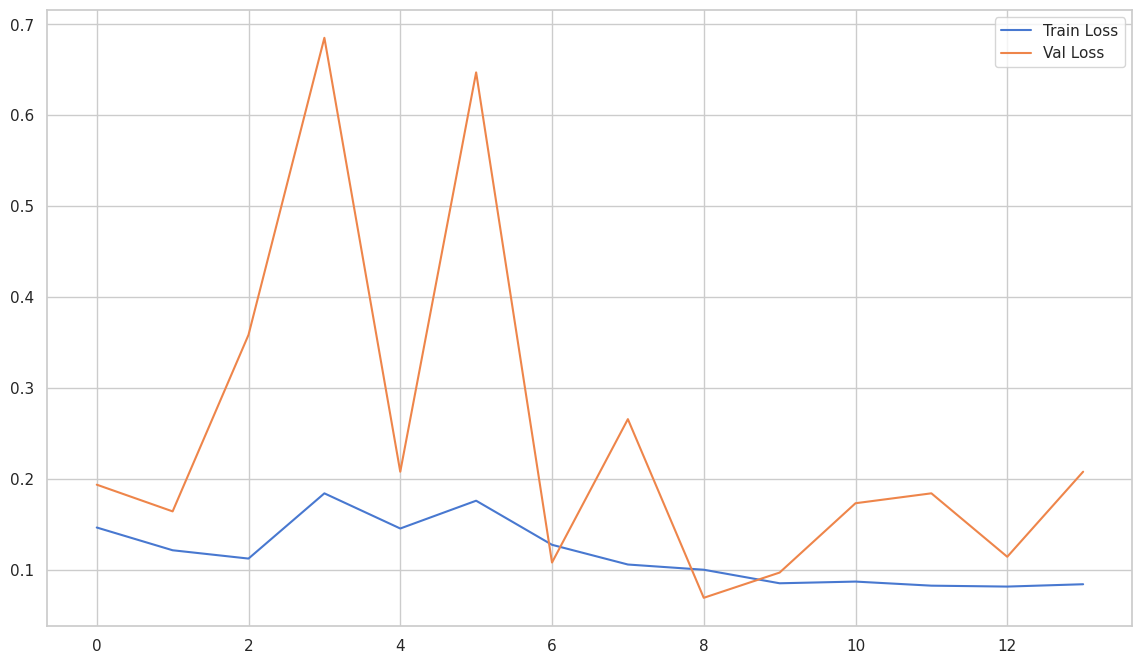

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

Here we can see that our validation loss was consistently higher than training loss. This means we over-fit on the training data. We can adjust this by tweaking on some of the hyper-parameters like model architecture and batch size and others. around last part of training, training loss and validation loss are converging.

We need to detect anomalies in our test data. So let's make some predictions and calculate the MAE on the training data.

In [11]:
# Get predictions on the training data
X_train_pred = model.predict(X_train)

# Next let's compute the mean absolute error of X_train_pred and X_train.
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])
train_mae_loss.head()

57/57 [==============================] - 3s 32ms/step


,Error
0,0.031318
1,0.031367
2,0.031436
3,0.031586
4,0.031809


In [13]:
# Model.evaluate shows us the total loss for the predictions. While the MAE we computed above was for each prediction.
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 25ms/step - loss: 0.1976


0.19755858182907104

loss for predictions in 0.19

Let's see the distribution of the MAE loss for the train data. kde is kernel density estimate tht's over laid on the distplot.

<ipython-input-14-70db697f1e66>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




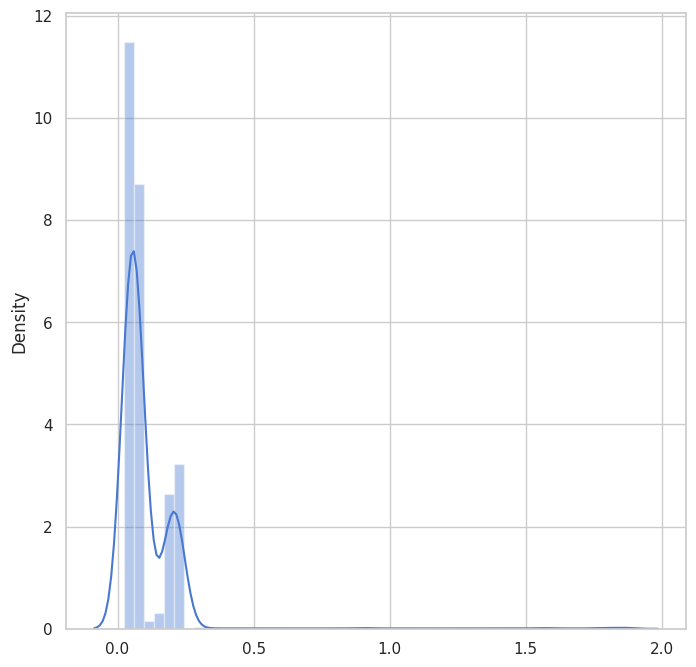

In [14]:
plt.figure(figsize=(8,8))
sns.distplot(train_mae_loss, bins=50, kde=True)
plt.show()

Okay, so let's set a threshold of say 0.10 on the x_axis. Since there is no much loss beyond it. This means any data above 0.10 is considered and labeled as anomaly.

In [15]:
# First let's get some predictions on the testing data
X_test_pred = model.predict(X_test)

# Next let's compute the mean absolute error of X_test_pred and X_test.
# MAE is so easy to compute:- find mean of abs(X_test_pred - X_test)
# Let's save it in a Data Frame

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


14/14 [==============================] - 0s 25ms/step


**Detect Anomalies in the Spacecraft SMA Data**

First we build a data frame with the loss and anomaly values(those exceeding the treshold)

In [16]:
threshold = 0.10
# values classified as anomalies are the ones that exceed the threshold
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['SMA'] = test[time_steps:].SMA


<ipython-input-17-8b44c794e107>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




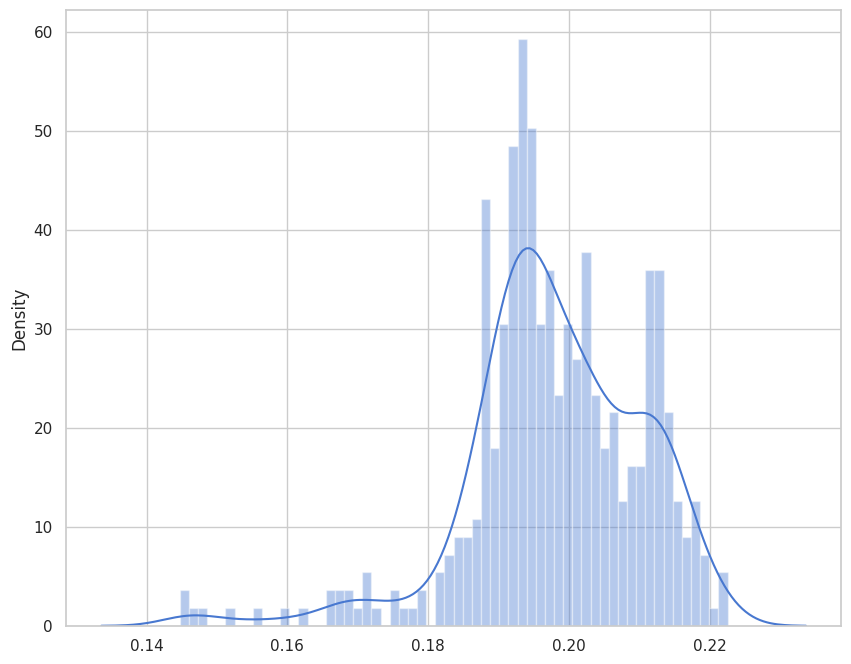

In [17]:
plt.figure(figsize=(10,8))
sns.distplot(test_mae_loss, bins=60, kde=True) # kde is kernel density estimate tht's over laid on the distplot.
plt.show()

All the values above the threshold are considered anomalies because their reconstruction error exceeds the threshold of 0.10.

let's create a Dataframe with only the extreme values and plot them and explore them with more granularity

In [18]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Datetime,SMA,loss,threshold,anomaly
1862,2019-08-14 05:02:14.248032,1.828720,0.195332,0.1,True
1863,2019-08-14 13:01:13.452384,1.828433,0.195106,0.1,True
1864,2019-08-14 20:55:09.522336,1.828187,0.194884,0.1,True
1865,2019-08-15 04:40:38.641152,1.827687,0.194670,0.1,True
1866,2019-08-15 09:17:17.454048,1.827515,0.194495,0.1,True


In [19]:
print(anomalies.shape)

(429, 5)


In [20]:
df.shape

(2291, 2)

According to this LSTM Autoencoder model, spacecraft maneuver count is 429 out of total 2291 data points.

However this is rough estimate and more fine tuning of parameters and threshold gives more reliable estimates.

In [21]:
anomalies.to_csv('/content/sample_data/manouveranomalynw.csv')